In [2]:
import pandas as pd
raw=pd.read_csv('tr_eikon_eod_data.csv',index_col=0,parse_dates=True).dropna()
symbol=['SPY','GLD','AAPL.O','MSFT.O']
noa=len(symbol)

In [3]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
from pylab import mpl,plt
plt.style.use('seaborn')
mpl.rcParams['font.family']='serif'
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FCBC211EF0>,
      dtype=object)

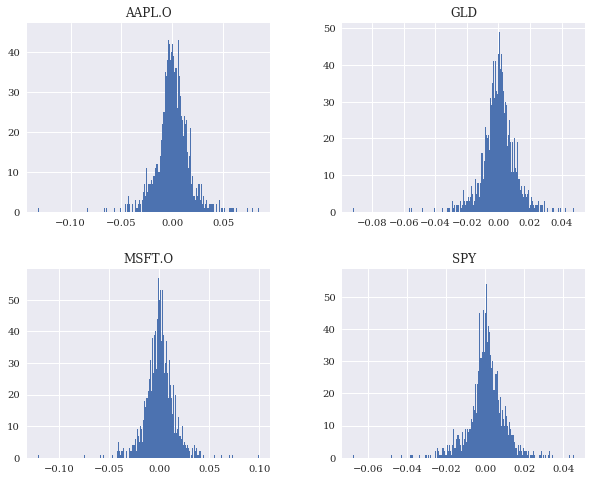

In [4]:
data=raw[symbol]
rets=np.log(data/data.shift(1))
rets.hist(bins=400,figsize=(10,8))

In [5]:
rets.head()

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,0.002644,-0.000911,0.001727,0.000323
2010-01-06,0.000704,0.016365,-0.016034,-0.006156
2010-01-07,0.004212,-0.006207,-0.001850,-0.010389
2010-01-08,0.003322,0.004951,0.006626,0.006807


In [6]:
rets.mean()*252

SPY       0.102928
GLD       0.009141
AAPL.O    0.212359
MSFT.O    0.136648
dtype: float64

In [7]:
rets.cov()*252

,SPY,GLD,AAPL.O,MSFT.O
SPY,0.021939,0.000062,0.021039,0.022244
GLD,0.000062,0.026209,0.001513,-0.000347
AAPL.O,0.021039,0.001513,0.063773,0.023427
MSFT.O,0.022244,-0.000347,0.023427,0.050917


In [8]:
#Variance * 252
#Std * sqrt(252)

In [9]:
rets.dropna(inplace=True)


In [10]:
rets.head()

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-05,0.002644,-0.000911,0.001727,0.000323
2010-01-06,0.000704,0.016365,-0.016034,-0.006156
2010-01-07,0.004212,-0.006207,-0.001850,-0.010389
2010-01-08,0.003322,0.004951,0.006626,0.006807
2010-01-11,0.001396,0.013202,-0.008861,-0.012802


In [11]:
weights=np.random.rand(noa)

In [12]:
weights

array([0.00904977, 0.61140689, 0.10628378, 0.43271968])

In [13]:
weights/=np.sum(weights)

In [14]:
sum(weights)

1.0

In [15]:
np.sum(rets.mean()*weights)*252

0.07608810524328913

In [16]:
rets.mean().shape

(4,)

In [17]:
weights.shape

(4,)

In [18]:
np.dot(weights.T,np.dot(rets.cov()*252,weights))

0.016689646964566877

In [19]:
def port_ret(weights):
    return np.sum(rets.mean()*weights)*252
def prot_vol(weights):
    return np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252,weights)))

In [20]:
prets=[]
pvols=[]
for p in range(2500):
    weights=np.random.rand(noa)
    weights/=np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(prot_vol(weights))


In [21]:
prets=np.array(prets)
pvols=np.array(pvols)

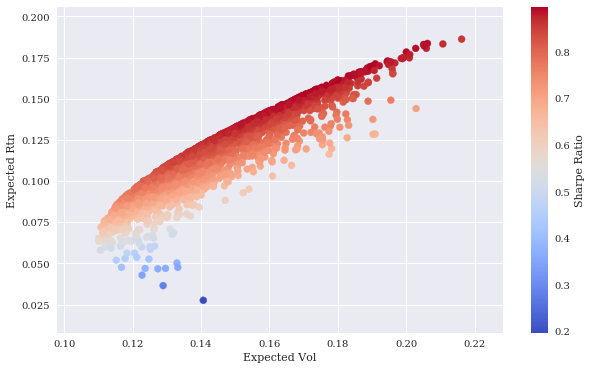

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(pvols,prets,c=prets/pvols,marker='o',cmap='coolwarm')
plt.xlabel("Expected Vol")
plt.ylabel("Expected Rtn")
plt.colorbar(label="Sharpe Ratio")
plt.show()

In [23]:
import scipy.optimize as sco

In [24]:
def min_f(weights):
    return -port_ret(weights)/prot_vol(weights)
cons=({'type':'eq','fun':lambda x: np.sum(x)-1})
bnds=tuple((0,1) for x in range(noa))

In [25]:
eweights=np.array(noa*[1/noa,])

In [26]:
min_f(eweights)

-0.84362033631554

In [27]:
%%time
opts=sco.minimize(min_f,eweights,method='SLSQP',bounds=bnds,constraints=cons)

Wall time: 97.7 ms


In [28]:
opts

     fun: -0.8976673894115292
     jac: array([-2.45958567e-04,  1.92746520e-05,  8.96975398e-05,  8.30292702e-05])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.25454111, 0.04228121, 0.51191357, 0.19126411])

In [29]:
opts['x'].round(3)

array([0.255, 0.042, 0.512, 0.191])

In [30]:
optv=sco.minimize(prot_vol,eweights,method="SLSQP",
                 bounds=bnds,constraints=cons)

In [31]:
optv

     fun: 0.10942155263386334
     jac: array([0.10939826, 0.10944918, 0.11098003, 0.10948556])
 message: 'Optimization terminated successfully.'
    nfev: 54
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([5.43263082e-01, 4.55675214e-01, 3.25260652e-19, 1.06170439e-03])

In [32]:
optv.x.round(3)

array([0.543, 0.456, 0.   , 0.001])

In [33]:
"why always me?"

'why always me?'